In [445]:
import itk
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from ca_iss_app.ca_iss_io import read_dicom_files
from ca_iss_app.ca_iss_features import convert_image_sitk_to_itk, convert_image_itk_to_sitk, cast_image
import math

In [263]:
preOpDir = 'D:\skola\DP\dp_source\input_files\pacient_08\ct_zavadec\\'
intraOpDir = 'D:\skola\DP\dp_source\input_files\pacient_08\ct\\'

In [264]:
preOpVolume = read_dicom_files(preOpDir)
intraOpVolume = read_dicom_files(intraOpDir)

print(f"Preop volume info: {preOpVolume.GetSize(), preOpVolume.GetSpacing(), preOpVolume.GetOrigin()}")
print(f"Intraop volume info: {intraOpVolume.GetSize(), intraOpVolume.GetSpacing(), intraOpVolume.GetOrigin()}")

IndexError: tuple index out of range

In [4]:
input_image_type = itk.Image[itk.SS, 3]
output_image_type = itk.Image[itk.UC, 3]

image_filter = itk.ResampleImageFilter[input_image_type, input_image_type].New()
image_filter.SetDefaultPixelValue(0)

transform = itk.CenteredEuler3DTransform[itk.D].New()
transform.SetComputeZYX(True)

interpolator = itk.itkRayCastInterpolateImageFunctionPython.itkRayCastInterpolateImageFunctionISS3D.New()

rescale_filter = sitk.RescaleIntensityImageFilter()

cast_filter = sitk.CastImageFilter()

In [458]:
def generate_drr(ct_volume: sitk.Image,
                 view: str = "ap",
                 src_img_dist: float = 1000.0,
                 drr_size: tuple[int, int] = (512, 512),
                 threshold: float = 200) -> sitk.Image:
    
    itk_volume = convert_image_sitk_to_itk(ct_volume) # convert sitk image to itk image
    image_filter.SetInput(itk_volume)

    # constant to convert degrees to radians
    deg_to_rad = (math.atan(1.0) * 4.0) / 180.0
    
    # default parameters, ap view
    rotation_x = -90. # in degrees
    rotation_z = 0.
    
    match view:
        case "lateral_left":
            rotation_z = 90.
        case "lateral_right":
            rotation_z = -90.
        case "pelvis_inlet":
            rotation_x = -135.
    
    transform.SetRotation(deg_to_rad * rotation_x, 0.0, deg_to_rad * rotation_z)

    ct_origin = itk_volume.GetOrigin()
    ct_spacing = itk_volume.GetSpacing()
    ct_size = itk_volume.GetLargestPossibleRegion().GetSize()
        
    ct_center = (ct_origin[0] + (ct_size[0] / 2.0) * ct_spacing[0],
                 ct_origin[1] + (ct_size[1] / 2.0) * ct_spacing[1],
                 ct_origin[2] + (ct_size[2] / 2.0) * ct_spacing[2])
    
    transform.SetCenter(ct_center)
    interpolator.SetTransform(transform)
    interpolator.SetThreshold(threshold)
    
    # sampling scale factor for images bigger than default
    default_drr_size = (512, 512)
    sampling_scale_factor = (drr_size[0] / default_drr_size[0],
                             drr_size[1] / default_drr_size[0])
        
    drr_spacing = (ct_spacing[0] / sampling_scale_factor[0],
                   ct_spacing[2] / sampling_scale_factor[1],
                   1.0)
    
    focal_point = (ct_center[0],
                   ct_center[1],
                   ct_center[2] + ((ct_size[1] / 2.0) * ct_spacing[1]) - src_img_dist)
    interpolator.SetFocalPoint(focal_point)

    drr_image_size = itk.Size[3]((drr_size[0],
                                  drr_size[1],
                                  1))

    drr_origin = (ct_origin[0],
                  ct_origin[1],
                  ct_origin[2] + ct_size[1] * ct_spacing[1] - 50)
    
    image_filter.SetSize(drr_image_size)
    image_filter.SetOutputSpacing(drr_spacing)
    image_filter.SetInterpolator(interpolator)
    image_filter.SetTransform(transform)
    image_filter.SetOutputOrigin(drr_origin)
    
    return convert_image_itk_to_sitk(image_filter.GetOutput())

In [461]:
drrImage = generate_drr(preOpVolume, view="ap", src_img_dist=1000.0, drr_size=(512, 512), threshold=200)

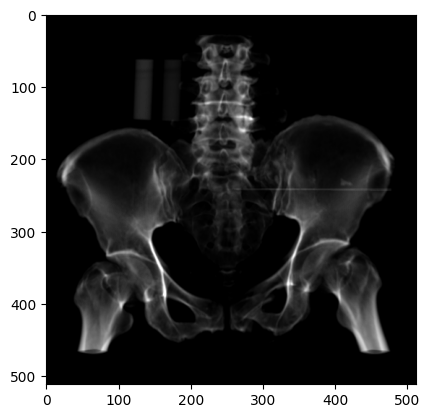

In [462]:
drrImageUint8 = cast_image(drrImage, "uint8")
drrImageView = sitk.GetArrayFromImage(drrImageUint8)
plt.imshow(drrImageView[0, :, :], cmap="gray")

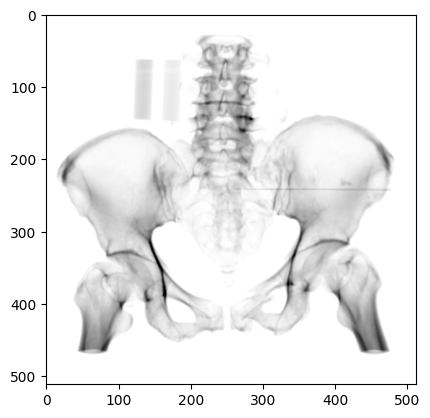

In [463]:
drrImageInverted = sitk.InvertIntensity(drrImageUint8)
drrImageInvertedArray = sitk.GetArrayFromImage(drrImageInverted)
plt.imshow(drrImageInvertedArray[0, :, :], cmap="gray")

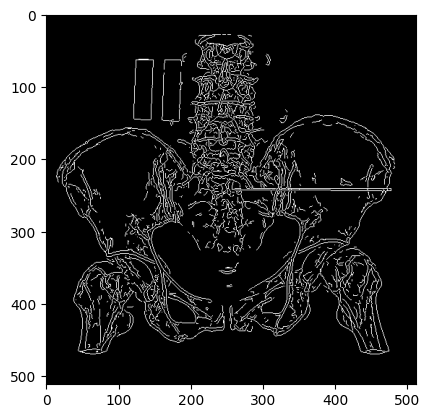

In [467]:
drrImageFloat = sitk.Cast(drrImage, sitk.sitkFloat32)
drrEdges = sitk.CannyEdgeDetection(drrImageFloat, lowerThreshold=500, upperThreshold=600)
drrEdgesArray = sitk.GetArrayFromImage(drrEdges)
plt.imshow(drrEdgesArray[0, :, :], cmap="gray")